In [1]:
%pip install sklearn
%pip install tensorflow
%pip install keras
%pip install tslearn
%pip install matplotlib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [2]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Dense, TimeDistributed, Reshape
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.regularizers import l2
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.preprocessing import TimeSeriesScalerMinMax
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')  # Ignorar las advertencias de Keras

In [3]:
ventas = pd.read_csv('C:/Users/German/OneDrive/Documentos/PROYECTOS/UA-MAESTRIA/21_Laboratorio de Implementación III/Clase 07/sell-in.txt', sep='\t')
productos = pd.read_csv('C:/Users/German/OneDrive/Documentos/PROYECTOS/UA-MAESTRIA/21_Laboratorio de Implementación III/Clase 07/tb_productos_descripcion.txt', sep='\t')
stock = pd.read_csv('C:/Users/German/OneDrive/Documentos/PROYECTOS/UA-MAESTRIA/21_Laboratorio de Implementación III/Clase 07/tb_stocks.txt', sep='\t')
productos_predecir = pd.read_csv('C:/Users/German/OneDrive/Documentos/PROYECTOS/UA-MAESTRIA/21_Laboratorio de Implementación III/Clase 07/productos_a_predecir.txt')

ventas_grouped = ventas.groupby(['periodo', 'product_id']).agg({
    'plan_precios_cuidados': 'sum',
    'cust_request_qty': 'sum', # sirve de algo para el modelo? En zulip se me menciona que es la cantidad de solicitudes que hace el cliente, por lo que creo que no
    'cust_request_tn': 'sum',
    'tn': 'sum'
}).reset_index()

ventas_producto = pd.merge(ventas_grouped, productos, on=['product_id'], how='inner')
final_dataset = pd.merge(ventas_producto, stock, on=['product_id', 'periodo'], how='left')
final_dataset = pd.merge(final_dataset, productos_predecir, on=['product_id'], how='inner')

final_dataset.to_csv('C:/Users/German/OneDrive/Documentos/PROYECTOS/UA-MAESTRIA/21_Laboratorio de Implementación III/Clase 08/dataset.csv', sep=',', index=False)

In [4]:
final_dataset.isnull().sum()

periodo                      0
product_id                   0
plan_precios_cuidados        0
cust_request_qty             0
cust_request_tn              0
tn                           0
cat1                         0
cat2                         0
cat3                         0
brand                        0
sku_size                     0
descripcion                  0
stock_final              11622
dtype: int64

In [5]:
final_dataset.head()

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final
0,201701,20001,0,479,937.72717,934.77222,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN
1,201702,20001,0,432,833.72187,798.01620,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN
2,201703,20001,0,509,1330.74697,1303.35771,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN
3,201704,20001,0,279,1132.94430,1069.96130,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN
4,201705,20001,0,701,1550.68936,1502.20132,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN


In [6]:
final_dataset.tail()

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final
22344,201912,21087,0,115,1.05790,1.02205,PC,DEOS,Aero,NIVEA,65,Clinical Original,5.79239
22345,201909,21214,0,3,0.34250,0.34250,PC,DEOS,RollOn,NIVEA,50,Aroma 14,2.59152
22346,201910,21214,0,46,0.21735,0.21735,PC,DEOS,RollOn,NIVEA,50,Aroma 14,1.65982
22347,201911,21214,0,88,0.84012,0.84012,PC,DEOS,RollOn,NIVEA,50,Aroma 14,0.52214
22348,201912,21214,0,55,0.24428,0.24428,PC,DEOS,RollOn,NIVEA,50,Aroma 14,2.69032


In [7]:
final_dataset[final_dataset['cust_request_tn'] != final_dataset['tn']]

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final
0,201701,20001,0,479,937.72717,934.77222,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN
1,201702,20001,0,432,833.72187,798.01620,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN
2,201703,20001,0,509,1330.74697,1303.35771,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN
3,201704,20001,0,279,1132.94430,1069.96130,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN
4,201705,20001,0,701,1550.68936,1502.20132,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22322,201910,20686,0,211,15.29067,14.99404,PC,CABELLO,SHAMPOO,NIVEA,400,fuerza total,39.84815
22324,201912,20686,0,168,9.89713,9.60049,PC,CABELLO,SHAMPOO,NIVEA,400,fuerza total,61.98351
22328,201912,20703,0,162,9.57806,9.46570,PC,CABELLO,Acond Mujer,NIVEA,400,Nueva vida,0.38653
22342,201910,21087,0,56,0.97972,0.90802,PC,DEOS,Aero,NIVEA,65,Clinical Original,4.12060


In [8]:
final_dataset.describe()

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,sku_size,stock_final
count,22349.000000,22349.000000,22349.000000,22349.000000,22349.000000,22349.000000,22349.000000,10727.000000
mean,201817.913687,20479.013423,1.249720,222.769744,51.364013,50.230669,447.639134,21.202147
std,81.433326,334.475371,12.981709,123.774437,129.425314,125.016406,831.235708,60.538364
min,201701.000000,20001.000000,0.000000,1.000000,0.000890,0.000890,1.000000,-13.666560
25%,201711.000000,20200.000000,0.000000,129.000000,3.010850,2.991610,89.000000,1.422785
50%,201809.000000,20411.000000,0.000000,207.000000,11.936620,11.900460,220.000000,6.120440
75%,201905.000000,20730.000000,0.000000,304.000000,36.272670,35.983630,475.000000,19.136220
max,201912.000000,21276.000000,289.000000,756.000000,2423.708810,2295.198320,10000.000000,1562.024480


In [9]:
final_dataset[(final_dataset['plan_precios_cuidados'] != 0) & (~final_dataset['plan_precios_cuidados'].isna())]

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final
396,201701,20012,172,386,491.10893,476.39728,HC,ROPA ACONDICIONADOR,ACONDICIONADOR,DOWNY,800,Sabor 15,NaN
397,201702,20012,185,349,554.77790,509.04048,HC,ROPA ACONDICIONADOR,ACONDICIONADOR,DOWNY,800,Sabor 15,NaN
398,201703,20012,205,567,665.79620,649.49079,HC,ROPA ACONDICIONADOR,ACONDICIONADOR,DOWNY,800,Sabor 15,NaN
399,201704,20012,190,496,755.65972,749.91517,HC,ROPA ACONDICIONADOR,ACONDICIONADOR,DOWNY,800,Sabor 15,NaN
932,201909,20026,143,359,210.99220,209.49245,HC,ROPA LAVADO,Liquido,LIMPIEX,800,Maquina 1er lavado,27.12045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21759,201908,20681,67,154,9.58617,9.58617,HC,HOGAR,Gel,MUSCULO,250,Gel 3 en 1,57.12376
21760,201909,20681,79,199,10.67498,10.67498,HC,HOGAR,Gel,MUSCULO,250,Gel 3 en 1,46.40773
21761,201910,20681,85,189,11.49681,11.49681,HC,HOGAR,Gel,MUSCULO,250,Gel 3 en 1,30.81752
21762,201911,20681,66,143,7.04877,7.04877,HC,HOGAR,Gel,MUSCULO,250,Gel 3 en 1,24.26914


In [10]:
ventas[(ventas['product_id'] == 20026) & (ventas['periodo'] == 201909) & (ventas['plan_precios_cuidados'] == 0)]

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn


In [11]:
def has_both_types(group):
    has_cuidados = (group['plan_precios_cuidados'] != 0).any()
    has_no_cuidados = (group['plan_precios_cuidados'] == 0).any()
    # display(group)
    return has_cuidados and has_no_cuidados

filtered_groups = ventas.groupby(['product_id', 'periodo']).filter(has_both_types)
filtered_groups

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn


In [12]:
final_dataset['plan_precios_cuidados'] = final_dataset['plan_precios_cuidados'].apply(lambda x: 1 if x > 0 else 0)

In [13]:
final_dataset[(final_dataset['plan_precios_cuidados'] != 0) & (~final_dataset['plan_precios_cuidados'].isna())]

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final
396,201701,20012,1,386,491.10893,476.39728,HC,ROPA ACONDICIONADOR,ACONDICIONADOR,DOWNY,800,Sabor 15,NaN
397,201702,20012,1,349,554.77790,509.04048,HC,ROPA ACONDICIONADOR,ACONDICIONADOR,DOWNY,800,Sabor 15,NaN
398,201703,20012,1,567,665.79620,649.49079,HC,ROPA ACONDICIONADOR,ACONDICIONADOR,DOWNY,800,Sabor 15,NaN
399,201704,20012,1,496,755.65972,749.91517,HC,ROPA ACONDICIONADOR,ACONDICIONADOR,DOWNY,800,Sabor 15,NaN
932,201909,20026,1,359,210.99220,209.49245,HC,ROPA LAVADO,Liquido,LIMPIEX,800,Maquina 1er lavado,27.12045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21759,201908,20681,1,154,9.58617,9.58617,HC,HOGAR,Gel,MUSCULO,250,Gel 3 en 1,57.12376
21760,201909,20681,1,199,10.67498,10.67498,HC,HOGAR,Gel,MUSCULO,250,Gel 3 en 1,46.40773
21761,201910,20681,1,189,11.49681,11.49681,HC,HOGAR,Gel,MUSCULO,250,Gel 3 en 1,30.81752
21762,201911,20681,1,143,7.04877,7.04877,HC,HOGAR,Gel,MUSCULO,250,Gel 3 en 1,24.26914


In [14]:
# Observo que tambien los Na de plan_precios_cuidados se mapearon a 0
final_dataset[final_dataset['plan_precios_cuidados'].isna()]

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final


In [82]:
final_dataset.to_csv('C:/Users/German/OneDrive/Documentos/PROYECTOS/UA-MAESTRIA/21_Laboratorio de Implementación III/Clase 08/final_dataset.csv', sep='\t', index=False)
final_dataset

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,...,stock_final,media,tn_netas,media_neta,stock_tn,cluster,tn_aj,log_tn,tn_lag12,tn_lag2
0,201701,20001,0,479,937.72717,934.77222,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,936.249695,934.77222,936.249695,NaN,2,934.77222,6.840303,NaN,NaN
1,201702,20001,0,432,833.72187,798.01620,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,815.869035,798.01620,815.869035,NaN,2,798.01620,6.682129,NaN,NaN
2,201703,20001,0,509,1330.74697,1303.35771,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1317.052340,1303.35771,1317.052340,NaN,2,1303.35771,7.172699,NaN,934.77222
3,201704,20001,0,279,1132.94430,1069.96130,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1101.452800,1069.96130,1101.452800,NaN,2,1069.96130,6.975378,NaN,798.01620
4,201705,20001,0,701,1550.68936,1502.20132,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1526.445340,1502.20132,1526.445340,NaN,2,1502.20132,7.314687,NaN,1303.35771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22344,201912,21087,0,115,1.05790,1.02205,PC,DEOS,Aero,NIVEA,...,5.79239,1.039975,-4.77034,-4.752415,5.667423,0,-4.77034,0.021810,1.99182,0.90802
22345,201909,21214,0,3,0.34250,0.34250,PC,DEOS,RollOn,NIVEA,...,2.59152,0.342500,-2.24902,-2.249020,7.566482,0,-2.24902,-1.071484,5.88702,1.39965
22346,201910,21214,0,46,0.21735,0.21735,PC,DEOS,RollOn,NIVEA,...,1.65982,0.217350,-1.44247,-1.442470,7.636623,0,-1.44247,-1.526246,4.07540,1.02205
22347,201911,21214,0,88,0.84012,0.84012,PC,DEOS,RollOn,NIVEA,...,0.52214,0.840120,0.31798,0.317980,0.621506,0,0.31798,-0.174211,2.68309,0.34250


In [16]:
final_dataset.isnull().sum()

periodo                      0
product_id                   0
plan_precios_cuidados        0
cust_request_qty             0
cust_request_tn              0
tn                           0
cat1                         0
cat2                         0
cat3                         0
brand                        0
sku_size                     0
descripcion                  0
stock_final              11622
dtype: int64

In [80]:
#final_dataset["log_tn"] = np.log(final_dataset["tn"])

In [81]:
final_dataset.head()

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,...,stock_final,media,tn_netas,media_neta,stock_tn,cluster,tn_aj,log_tn,tn_lag12,tn_lag2
0,201701,20001,0,479,937.72717,934.77222,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,936.249695,934.77222,936.249695,NaN,2,934.77222,6.840303,NaN,NaN
1,201702,20001,0,432,833.72187,798.01620,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,815.869035,798.01620,815.869035,NaN,2,798.01620,6.682129,NaN,NaN
2,201703,20001,0,509,1330.74697,1303.35771,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1317.052340,1303.35771,1317.052340,NaN,2,1303.35771,7.172699,NaN,934.77222
3,201704,20001,0,279,1132.94430,1069.96130,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1101.452800,1069.96130,1101.452800,NaN,2,1069.96130,6.975378,NaN,798.01620
4,201705,20001,0,701,1550.68936,1502.20132,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1526.445340,1502.20132,1526.445340,NaN,2,1502.20132,7.314687,NaN,1303.35771


In [71]:
final_dataset.head()

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,...,stock_final,media,tn_netas,media_neta,stock_tn,cluster,tn_aj,log_tn,tn_lag12,tn_lag2
0,201701,20001,0,479,937.72717,934.77222,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,936.249695,934.77222,936.249695,NaN,2,934.77222,6.840303,NaN,NaN
1,201702,20001,0,432,833.72187,798.01620,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,815.869035,798.01620,815.869035,NaN,2,798.01620,6.682129,NaN,NaN
2,201703,20001,0,509,1330.74697,1303.35771,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1317.052340,1303.35771,1317.052340,NaN,2,1303.35771,7.172699,NaN,934.77222
3,201704,20001,0,279,1132.94430,1069.96130,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1101.452800,1069.96130,1101.452800,NaN,2,1069.96130,6.975378,NaN,798.01620
4,201705,20001,0,701,1550.68936,1502.20132,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1526.445340,1502.20132,1526.445340,NaN,2,1502.20132,7.314687,NaN,1303.35771


In [72]:
final_dataset.to_csv('C:/Users/German/OneDrive/Documentos/PROYECTOS/UA-MAESTRIA/21_Laboratorio de Implementación III/Clase 08/final_dataset.csv', index=False)

In [73]:
# Cargar el dataset
df = pd.read_csv('C:/Users/German/OneDrive/Documentos/PROYECTOS/UA-MAESTRIA/21_Laboratorio de Implementación III/Clase 08/final_dataset.csv', sep=",")

In [74]:
df.head()

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,...,stock_final,media,tn_netas,media_neta,stock_tn,cluster,tn_aj,log_tn,tn_lag12,tn_lag2
0,201701,20001,0,479,937.72717,934.77222,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,936.249695,934.77222,936.249695,NaN,2,934.77222,6.840303,NaN,NaN
1,201702,20001,0,432,833.72187,798.01620,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,815.869035,798.01620,815.869035,NaN,2,798.01620,6.682129,NaN,NaN
2,201703,20001,0,509,1330.74697,1303.35771,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1317.052340,1303.35771,1317.052340,NaN,2,1303.35771,7.172699,NaN,934.77222
3,201704,20001,0,279,1132.94430,1069.96130,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1101.452800,1069.96130,1101.452800,NaN,2,1069.96130,6.975378,NaN,798.01620
4,201705,20001,0,701,1550.68936,1502.20132,HC,ROPA LAVADO,Liquido,ARIEL,...,NaN,1526.445340,1502.20132,1526.445340,NaN,2,1502.20132,7.314687,NaN,1303.35771


In [75]:
df.tail()

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,...,stock_final,media,tn_netas,media_neta,stock_tn,cluster,tn_aj,log_tn,tn_lag12,tn_lag2
22344,201912,21087,0,115,1.05790,1.02205,PC,DEOS,Aero,NIVEA,...,5.79239,1.039975,-4.77034,-4.752415,5.667423,0,-4.77034,0.021810,1.99182,0.90802
22345,201909,21214,0,3,0.34250,0.34250,PC,DEOS,RollOn,NIVEA,...,2.59152,0.342500,-2.24902,-2.249020,7.566482,0,-2.24902,-1.071484,5.88702,1.39965
22346,201910,21214,0,46,0.21735,0.21735,PC,DEOS,RollOn,NIVEA,...,1.65982,0.217350,-1.44247,-1.442470,7.636623,0,-1.44247,-1.526246,4.07540,1.02205
22347,201911,21214,0,88,0.84012,0.84012,PC,DEOS,RollOn,NIVEA,...,0.52214,0.840120,0.31798,0.317980,0.621506,0,0.31798,-0.174211,2.68309,0.34250
22348,201912,21214,0,55,0.24428,0.24428,PC,DEOS,RollOn,NIVEA,...,2.69032,0.244280,-2.44604,-2.446040,11.013263,0,-2.44604,-1.409440,1.69045,0.21735


In [76]:
# Crear una función para generar secuencias de tiempo
def create_sequences(data, look_back):
    sequences = []
    for i in range(len(data) - look_back):
        sequence = data[i:(i + look_back)]
        sequences.append(sequence)
    return np.array(sequences)


In [77]:
# Establecer las semillas para numpy, random y tensorflow/keras
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

In [78]:
df_modif = df

In [79]:
from sklearn.preprocessing import RobustScaler

In [83]:
# Obtener los IDs únicos de los productos
unique_product_ids = df_modif['product_id'].unique()

# Agrupar productos por histórico de toneladas
historical_data = []
for product_id in unique_product_ids:
    product_data = df_modif[df_modif['product_id'] == product_id]
    produccion = product_data['tn'].values.reshape(-1, 1)

    # Imputar valores NaN con la media del producto
    imputer = SimpleImputer(strategy='median') #Podría ser median o mean
    produccion_imputed = imputer.fit_transform(produccion)

    historical_data.append(produccion_imputed.flatten())

# Asegurarse de que todas las series de tiempo tengan la misma longitud
max_length = max(map(len, historical_data))
historical_data = np.array([np.pad(h, (0, max_length - len(h)), 'constant') for h in historical_data])

# Usar KMeans para agrupar productos en 5 grupos (puedes ajustar el número de grupos)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)  # Establecer n_init explícitamente
clusters = kmeans.fit_predict(historical_data)

# Añadir la información de clusters al DataFrame original
df_modif['cluster'] = df_modif['product_id'].map(dict(zip(unique_product_ids, clusters)))

# Lista para almacenar las predicciones
predictions = []

# Lista para almacenar productos sin predicción
no_predictions = []

# Loop a través de cada cluster
for cluster in range(n_clusters):
    # Seleccionar los productos en el cluster actual
    cluster_data = df_modif[df_modif['cluster'] == cluster]

    # Lista para almacenar los datos normalizados por producto
    normalized_data = []
    scalers = {}

    for product_id in cluster_data['product_id'].unique():
        product_data = cluster_data[cluster_data['product_id'] == product_id]

        # Normalizar la producción para escalar de manera consistente
        #scaler = MinMaxScaler()
        scaler = RobustScaler()
        produccion_normalizada = scaler.fit_transform(product_data['tn'].values.reshape(-1, 1))

        normalized_data.append(produccion_normalizada)
        scalers[product_id] = scaler

    # Crear secuencias para el cluster
    look_back = 12  # Número de meses pasados a considerar
    
    cluster_sequences = []
    for data in normalized_data:
        sequences = create_sequences(data, look_back)
        if len(sequences) > 0:
            cluster_sequences.extend(sequences)
        
    cluster_sequences = np.array(cluster_sequences)

    if len(cluster_sequences) == 0:
        continue  # Saltar al siguiente cluster si no hay secuencias

    # Separar las características (X) y los valores objetivo (y) para el entrenamiento
    X = cluster_sequences[:, :-1]  # Todas las características excepto el último mes (objetivo)
    y = cluster_sequences[:, -1]   # Último mes (objetivo)

    # Preparar los datos para cada producto
    all_sequences = []
    all_targets = []

    # Reformatear los datos para que se ajusten al modelo
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Definir el modelo CNN-BiLSTM
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='leaky_relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Reshape((X.shape[1] // 2, 64)))  # Reformatear para que sea compatible con Bidirectional LSTM
    model.add(Bidirectional(LSTM(50, activation='leaky_relu'))) #relu
    model.add(Dense(15)) # era 3
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    #model.fit(X, y, epochs=100, batch_size=32, verbose=1)
    # Configurar early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # Entrenar el modelo con early stopping
    model.fit(X, y, epochs=500, batch_size=36, validation_split=0.1, callbacks=[early_stopping])

    # Realizar predicciones para cada producto en el cluster
    for product_id in cluster_data['product_id'].unique():
        product_data = cluster_data[cluster_data['product_id'] == product_id]
        produccion_normalizada = normalized_data[list(cluster_data['product_id'].unique()).index(product_id)]

        # Crear secuencias para el producto actual
        sequences = create_sequences(produccion_normalizada, look_back)
        if len(sequences) == 0:
            no_predictions.append({'product_id': product_id, 'reason': 'Insufficient data for sequence creation'})
            continue  # Saltar al siguiente producto si no hay secuencias

        X_product = sequences[:, :-1]  # Todas las características excepto el último mes (objetivo)
        X_product = X_product.reshape((X_product.shape[0], X_product.shape[1], 1))

        # Realizar la predicción del próximo mes (periodo 1)
        primera_prediccion_normalizada = model.predict(np.array([X_product[-1]]))

        # Añadir la predicción del próximo mes a la secuencia para predecir el mes siguiente (periodo 2)
        nueva_secuencia = np.append(X_product[-1][1:], [[primera_prediccion_normalizada.flatten()[0]]], axis=0)
        nueva_secuencia = nueva_secuencia.reshape((1, nueva_secuencia.shape[0], 1))

        # Realizar la predicción del mes dos (periodo 2)
        segunda_prediccion_normalizada = model.predict(nueva_secuencia)
        segunda_prediccion = scalers[product_id].inverse_transform(segunda_prediccion_normalizada.reshape(-1, 1))

        # Almacenar el ID del producto y la predicción en la lista de predicciones
        predictions.append({'product_id': product_id, 'prediccion_produccion': segunda_prediccion.flatten()[0]})

        
# Convertir la lista de predicciones en un DataFrame
predictions_df = pd.DataFrame(predictions)
no_predictions_df = pd.DataFrame(no_predictions)

# Calcular el promedio de los últimos 12 meses para los productos sin predicción
final_dataset = df_modif  # Asegúrate de que 'final_dataset' esté definido o reemplázalo por el nombre correcto

for index, row in no_predictions_df.iterrows():
    product_id = row['product_id']
    product_data = final_dataset[final_dataset['product_id'] == product_id]
    if len(product_data) >= 12:
        promedio = product_data['tn'].iloc[-12:].median() # Podría cambiar por mean
    else:
        promedio = product_data['tn'].median()  # Si no hay suficientes datos, usar el promedio general
    predictions.append({'product_id': product_id, 'prediccion_produccion': promedio})


# Convertir la lista de predicciones en un DataFrame
final_predictions_df = pd.DataFrame(predictions)

#Resumen del modelo
model.summary()
    
    

Epoch 1/500
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5453 - val_loss: 0.5593
Epoch 2/500
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5150 - val_loss: 0.5610
Epoch 3/500
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5046 - val_loss: 0.5571
Epoch 4/500
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4990 - val_loss: 0.5525
Epoch 5/500
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4957 - val_loss: 0.5504
Epoch 6/500
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4931 - val_loss: 0.5509
Epoch 7/500
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4905 - val_loss: 0.5527
Epoch 8/500
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4876 - val_loss: 0.5578
Epoch 9/500
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4849 - val_loss: 0.5624
Epoch 10/500
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4819 - val_loss: 0.5658
Epoch 11/500
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4791 - val_loss: 0.5668
Epoch 12/500
270/270 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)              │ (None, 10, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_33 (Reshape)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_33                │ (None, 100)            │        46,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 15)             │         1,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,123 (559.08 KB)

 Trainable params: 47,707 (186.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 95,416 (372.72 KB)

In [84]:
# Guardar el DataFrame como un archivo CSV
final_predictions_df.to_csv('C:/Users/German/OneDrive/Documentos/PROYECTOS/UA-MAESTRIA/21_Laboratorio de Implementación III/Clase 08/predicion_cnn_lstm_v01_3_1.csv', index=False)

# Informar el número de productos sin predicción
print(f"Number of products without prediction: {len(no_predictions)}")



Number of products without prediction: 124


In [64]:
# Cargar el dataset
#pred = pd.read_csv('C:/Users/German/OneDrive/Documentos/PROYECTOS/UA-MAESTRIA/21_Laboratorio de Implementación III/Clase 08/predicion_cnn_lstm_v01_3_1.csv', sep=",")

In [65]:
#pred["tn"] = np.exp(pred["prediccion_produccion"])

In [66]:
#pred = pred.drop(columns=['prediccion_produccion'])

In [67]:
#pred.to_csv('C:/Users/German/OneDrive/Documentos/PROYECTOS/UA-MAESTRIA/21_Laboratorio de Implementación III/Clase 08/predicion_cnn_lstm_v02_3_1.csv', index=False)

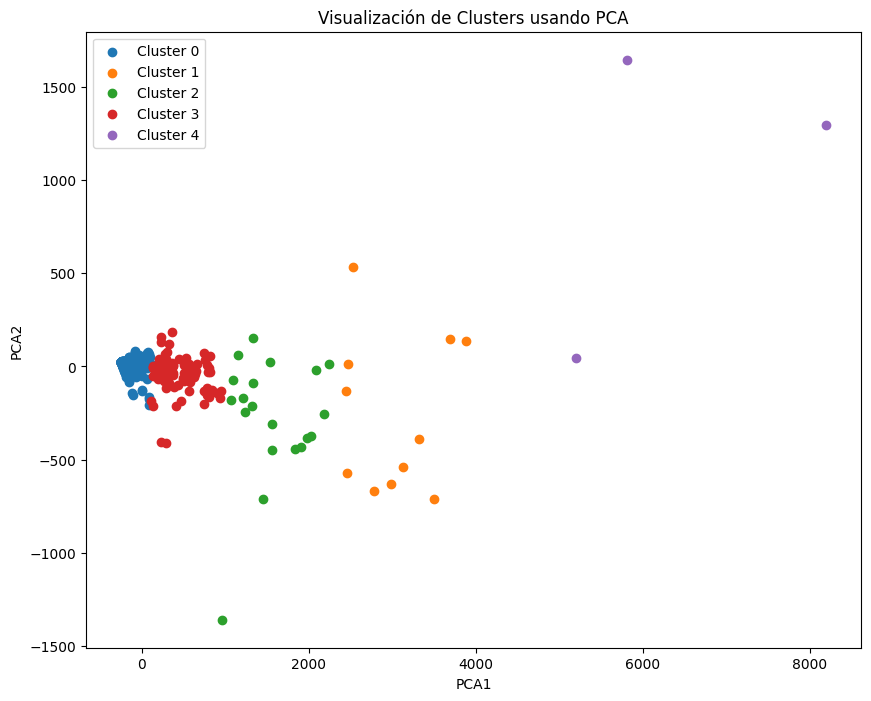

Cluster 0:
[20139, 20140, 20142, 20144, 20145, 20148, 20152, 20153, 20155, 20157, 20158, 20160, 20161, 20162, 20166, 20167, 20168, 20175, 20176, 20177, 20179, 20180, 20181, 20182, 20183, 20184, 20187, 20188, 20189, 20192, 20193, 20196, 20197, 20198, 20200, 20201, 20205, 20206, 20207, 20208, 20209, 20211, 20212, 20215, 20216, 20219, 20220, 20222, 20224, 20225, 20226, 20227, 20228, 20230, 20231, 20232, 20233, 20234, 20235, 20238, 20239, 20240, 20241, 20242, 20244, 20246, 20249, 20251, 20252, 20253, 20254, 20255, 20256, 20259, 20263, 20264, 20265, 20267, 20268, 20269, 20270, 20271, 20272, 20273, 20275, 20276, 20277, 20278, 20280, 20281, 20282, 20283, 20284, 20285, 20288, 20289, 20290, 20291, 20292, 20295, 20296, 20299, 20300, 20301, 20302, 20303, 20304, 20305, 20307, 20309, 20310, 20311, 20313, 20314, 20315, 20316, 20317, 20320, 20321, 20322, 20324, 20325, 20326, 20327, 20328, 20329, 20330, 20332, 20335, 20336, 20338, 20341, 20342, 20346, 20349, 20350, 20352, 20353, 20354, 20356, 20357, 2

In [85]:
#Grafico con n cluster
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Usar PCA para reducir la dimensionalidad de los datos históricos
pca = PCA(n_components=2)
historical_data_pca = pca.fit_transform(historical_data)

# Crear un DataFrame para facilitar la visualización
pca_df = pd.DataFrame(historical_data_pca, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = clusters
pca_df['product_id'] = unique_product_ids

# Visualizar los clusters
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_data = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Visualización de Clusters usando PCA')
plt.legend()
plt.show()

# Mostrar qué productos están en cada cluster
for cluster in range(n_clusters):
    print(f"Cluster {cluster}:")
    cluster_products = pca_df[pca_df['cluster'] == cluster]['product_id']
    print(cluster_products.tolist())
    print()


In [40]:
# Probar con media, tn_netas y media_neta